In [1]:
# Cell 1: Imports (Modified)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import logging
import time
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

# --- Qiskit Imports ---
try:
    # Primitives V2
    from qiskit.primitives import Estimator as RefEstimator
    from qiskit.circuit import QuantumCircuit, ParameterVector
    from qiskit.quantum_info import SparsePauliOp
    from qiskit_machine_learning.connectors import TorchConnector
    from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN

    # Aer Simulator and Primitives V2 wrapper
    from qiskit_aer.primitives import Estimator as AerEstimator
    from qiskit_aer import AerSimulator, QasmSimulator

    # Noise Modeling
    from qiskit_aer.noise import NoiseModel, depolarizing_error

    # Circuit Libraries (for Encodings)
    from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, NLocal, TwoLocal

    # Log the qiskit-machine-learning version
    import qiskit_machine_learning
    logging.info(f"Using qiskit-machine-learning version: {qiskit_machine_learning.__version__}")
    import qiskit_aer
    logging.info(f"Using qiskit-aer version: {qiskit_aer.__version__}")
    import qiskit
    logging.info(f"Using qiskit version: {qiskit.__version__}")


except ImportError as e:
    logging.error(f"Failed to import Qiskit components: {e}. Ensure qiskit>=1.0, qiskit-aer, and qiskit-machine-learning are installed and compatible.")
    raise

# # Logging setup (can be in a separate cell or here)
# logging.basicConfig(level=logging.INFO,
#                     format='%(asctime)s - %(levelname)s - %(message)s',
#                     force=True)
# logger = logging.getLogger(__name__)
# logger.info('Logging configured.')

# --- Global Estimator Setup (moved to a function for flexibility) ---
# Placeholder for the estimator, will be set by create_estimator function
GLOBAL_ESTIMATOR = None

# --- Add this code to the end of your first cell ---

# --- Add this to silence Qiskit logs ---
import warnings

# 1. Silence the noisy Qiskit INFO logs
logging.getLogger('qiskit_aer').setLevel(logging.WARNING)
logging.getLogger('qiskit.transpiler').setLevel(logging.WARNING)
logging.getLogger('qiskit_machine_learning').setLevel(logging.WARNING)
logger = logging.getLogger(__name__)
# 2. Silence that specific RuntimeWarning from Aer
warnings.filterwarnings(
    "ignore",
    message="If `shots` is None and `approximation` is False, the number of shots is automatically set to backend options' shots=1024."
)

logger.info("Qiskit log levels set to WARNING to reduce noise.")
# --- End of new code ---

In [2]:
# Cell 2: Estimator Creation Function
def create_estimator(simulator_name: str = 'reference', noise_level: float = 0.0):
    """
    Creates a Qiskit Estimator primitive based on the chosen simulator and noise level.

    Args:
        simulator_name: 'reference', 'aer_statevector', 'aer_density_matrix', 'aer_mps'.
        noise_level: Probability of depolarizing error (0.0 for noiseless).

    Returns:
        A Qiskit Estimator primitive instance.
    """
    global GLOBAL_ESTIMATOR # To modify the global variable

    sim_name_lower = simulator_name.lower()
    backend = None
    estimator_instance = None
    noise_model = None

    logger.info(f"Creating Estimator with simulator='{simulator_name}', noise_level={noise_level}")

    # --- Noise Model Setup ---
    if noise_level > 0 and 'aer' in sim_name_lower:
        # Simple depolarizing noise model
        error_1q = depolarizing_error(noise_level, 1)
        error_2q = depolarizing_error(noise_level, 2)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_1q, ['rx', 'ry', 'rz', 'h', 's', 'sdg', 't', 'tdg', 'id']) # Add relevant 1q gates
        noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'cz', 'swap']) # Add relevant 2q gates
        logger.info(f"Applied depolarizing noise model with error probability: {noise_level}")

    # --- Simulator Backend Setup ---
    if 'aer' in sim_name_lower:
        method = 'automatic' # Default
        if 'statevector' in sim_name_lower:
            method = 'statevector'
        elif 'density_matrix' in sim_name_lower:
            method = 'density_matrix'
        elif 'mps' in sim_name_lower:
            method = 'matrix_product_state'

        aer_sim_opts = {'method': method}
        if noise_model:
            aer_sim_opts['noise_model'] = noise_model
            # Noisy sims often don't work well with snapshot optimizations
            aer_sim_opts['enable_truncation'] = False
            # Can add more AerSimulator options here if needed

        backend = AerSimulator(**aer_sim_opts)
        # Use Aer's V2 Estimator primitive wrapper
        # Pass backend_options directly for AerSimulator control
        estimator_instance = AerEstimator(backend_options=aer_sim_opts, run_options={'shots': None}) # Statevector uses shots=None
        if noise_level > 0:
             # Density matrix or noisy statevector often need shots
             estimator_instance = AerEstimator(backend_options=aer_sim_opts, run_options={'shots': 128})
             logger.info("Using 1024 shots for noisy simulation.")

        logger.info(f"Using AerEstimator with method='{method}'.")
    
    elif 'qasm' in sim_name_lower:
        method = 'automatic' # Default
        if 'statevector' in sim_name_lower:
            method = 'statevector'
        elif 'density_matrix' in sim_name_lower:
            method = 'density_matrix'
        elif 'mps' in sim_name_lower:
            method = 'matrix_product_state'

        qasm_sim_opts = {'method': method}
        if noise_model:
            aer_sim_opts['noise_model'] = noise_model
            # Noisy sims often don't work well with snapshot optimizations
            aer_sim_opts['enable_truncation'] = False
            # Can add more AerSimulator options here if needed

        backend = QasmSimulator(**qasm_sim_opts)
        # Use Aer's V2 Estimator primitive wrapper
        # Pass backend_options directly for AerSimulator control
        estimator_instance = QasmSimulator(backend_options=qasm_sim_opts, run_options={'shots': None}) # Statevector uses shots=None
        if noise_level > 0:
             # Density matrix or noisy statevector often need shots
             estimator_instance = QasmSimulator(backend_options=qasm_sim_opts, run_options={'shots': 128})
             logger.info("Using 1024 shots for noisy simulation.")
        logger.info(f"Using QasmSimulator with method='{method}'.")

    elif sim_name_lower == 'reference':
        # Use Qiskit's reference Estimator (pure Python, good for debugging, noiseless)
        if noise_level > 0:
            logger.warning("Reference Estimator does not support noise models. Running noiseless.")
        estimator_instance = RefEstimator()
        logger.info("Using qiskit.primitives.Estimator (Reference, noiseless).")
    else:
        raise ValueError(f"Unknown simulator_name: '{simulator_name}'. Choose 'reference', 'aer_statevector', 'aer_density_matrix', or 'aer_mps'.")

    GLOBAL_ESTIMATOR = estimator_instance # Set the global variable
    return estimator_instance

# Example: Create the default estimator at the start
create_estimator() # Creates the reference estimator by default

C:\Users\PARAM\AppData\Local\Temp\ipykernel_4732\648960325.py:90: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator_instance = RefEstimator()


In [3]:
# ...existing code...
from pathlib import Path
DATA_PATH = Path("D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\creditcard_data.csv")
assert DATA_PATH.exists(), f'Not found: {DATA_PATH}'
data = pd.read_csv(DATA_PATH)
# ...existing code...

In [20]:
from torch.utils.data import DataLoader, Dataset, random_split
class FraudDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.indices = torch.arange(len(features))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.indices[idx]

In [21]:
def get_fraud_dataloaders(data_path: str, batch_size: int, n_fraud_points: int = 200, n_non_fraud_points: int = 600, n_components: int = 8):
    DATA_PATH = Path("D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\creditcard_data.csv")
    assert DATA_PATH.exists(), f'Not found: {DATA_PATH}'
    data = pd.read_csv(DATA_PATH)
    
    data_fraud = data.loc[data['Class'] == 1]
    data_non_fraud = data.loc[data['Class'] == 0]

    data_fraud_train = data_fraud.sample(n=n_fraud_points, random_state=42)
    data_fraud_test = data_fraud.drop(index=data_fraud_train.index)
    data_non_fraud_train = data_non_fraud.sample(n=n_non_fraud_points, random_state=42)
    data_non_fraud_test = data_non_fraud.drop(index=data_non_fraud_train.index)

    data_train = pd.concat([data_non_fraud_train, data_fraud_train])
    data_test = pd.concat([data_non_fraud_test, data_fraud_test])

    x_train = data_train.drop(['Time', 'Class'], axis=1).values
    y_train = data_train['Class'].values
    x_test = data_test.drop(['Time', 'Class'], axis=1).values
    y_test = data_test['Class'].values

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)
    
    print(f"Data processed. Train shape: {x_train_pca.shape}, Test shape: {x_test_pca.shape}")

    train_dataset = FraudDataset(features=x_train_pca, labels=y_train)
    test_dataset = FraudDataset(features=x_test_pca, labels=y_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader


In [22]:
# Cell 3: Quantum Encoder Module (Modified)
class QiskitQuantumEncoder(nn.Module):
    """ Quantum encoder using Qiskit EstimatorQNN and TorchConnector """
    def __init__(self, n_qubits: int, q_depth: int, encoding_map_type: str = 'angle', reps: int = 1):
        """
        Args:
            n_qubits: Number of qubits.
            q_depth: Depth of the variational circuit part (e.g., NLocal reps).
            encoding_map_type: 'angle', 'zz', 'pauli'.
            reps: Repetitions for ZZFeatureMap/PauliFeatureMap (usually 1 for encoding).
        """
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth # Depth of variational part
        self.encoding_map_type = encoding_map_type.lower()
        self.reps = reps # Reps for feature map

        if GLOBAL_ESTIMATOR is None:
            raise RuntimeError("GLOBAL_ESTIMATOR not set. Call create_estimator() first.")

        # --- Input Parameters (depend on encoding) ---
        self.input_params = ParameterVector('x', self.n_qubits) # Default for angle

        # --- Feature Map Part ---
        feature_map: QuantumCircuit | None = None
        if self.encoding_map_type == 'angle':
            # Simple Angle Encoding (as before, part of the main circuit build later)
            feature_map = QuantumCircuit(self.n_qubits, name='AngleEnc')
            # Apply initial H gates often used with angle encoding
            feature_map.h(range(self.n_qubits))
            for i, p in enumerate(self.input_params):
                feature_map.ry(p, i)

        elif self.encoding_map_type == 'zz':
            # ZZ Feature Map
            if self.n_qubits < 2:
                 raise ValueError("ZZFeatureMap requires at least 2 qubits.")
            feature_map = ZZFeatureMap(feature_dimension=self.n_qubits, reps=self.reps, entanglement='linear')
            self.input_params = feature_map.parameters # Use parameters defined by the map

        elif self.encoding_map_type == 'pauli':
            # Pauli Feature Map
            feature_map = PauliFeatureMap(feature_dimension=self.n_qubits, reps=self.reps, paulis=['Z', 'Y', 'ZZ']) # Example Paulis
            self.input_params = feature_map.parameters # Use parameters defined by the map

        else:
            raise ValueError(f"Unknown encoding_map_type: {self.encoding_map_type}")

        logger.info(f"Using encoding map: {self.encoding_map_type} with {len(self.input_params)} input parameters.")

        # --- Variational Circuit Part (Ansatz) ---
        # Using NLocal as a standard example (like TwoLocal but more flexible)
        # Rotation blocks: RY gates
        # Entanglement blocks: Linear CX gates
        num_weights = (self.q_depth + 1) * self.n_qubits
        self.weight_params = ParameterVector('w', num_weights)
        # self.weight_params = ParameterVector('w', self.q_depth * 2 * self.n_qubits) # Parameters for RY weights
        rotation_blocks = ['ry'] * self.n_qubits
        entanglement_blocks = 'cx'

        ansatz = TwoLocal(
            num_qubits=self.n_qubits,
            rotation_blocks='ry',
            entanglement_blocks=entanglement_blocks,
            entanglement='linear', # or 'circular', 'full', etc.
            reps=self.q_depth, # q_depth now refers to ansatz reps
            parameter_prefix='w', # Match self.weight_params prefix if needed, or manage manually
            name='VarAnsatz'
        )
        # Manually assign the ParameterVector to the ansatz's parameters
        # This ensures the names match what EstimatorQNN expects
        # Note: This assumes NLocal parameter ordering matches ParameterVector filling. Check if issues arise.
        ansatz.assign_parameters(self.weight_params, inplace=True)

        logger.info(f"Using variational ansatz: NLocal (linear CX) with depth {self.q_depth}, {len(self.weight_params)} weight parameters.")

        # --- Combine Feature Map and Ansatz ---
        qc = QuantumCircuit(self.n_qubits, name='QSVDD_Circuit')
        qc.compose(feature_map, inplace=True)
        qc.barrier()
        qc.compose(ansatz, inplace=True)

        # --- Observables (remain the same) ---
        observables = [
            SparsePauliOp.from_list([("I" * i + "Z" + "I" * (self.n_qubits - 1 - i), 1)])
            for i in range(self.n_qubits)
        ]

        # --- EstimatorQNN Setup ---
        # Explicitly set gradient=None to rely on the default mechanism
        self.qnn = EstimatorQNN(
            circuit=qc,
            observables=observables,
            input_params=self.input_params,      # Parameters from the feature map
            weight_params=self.weight_params,    # Parameters from the ansatz
            input_gradients=False,
            estimator=GLOBAL_ESTIMATOR,          # Use the globally configured estimator
            gradient=None
        )

        # Initialize weights for TorchConnector
        init_w = (2 * np.random.rand(self.qnn.num_weights) - 1) * 0.1
        self.torch_layer = TorchConnector(self.qnn, initial_weights=init_w.astype(np.float64))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass. Includes basic scaling suitable for feature maps.
        """
        if x.dim() == 1: x = x.unsqueeze(0)
        if x.shape[1] != self.n_qubits:
             # ZZ/Pauli maps might sometimes use fewer params than qubits depending on config,
             # but PCA output is matched to n_qubits, so this check should still hold.
             raise ValueError(f"Input feature dimension {x.shape[1]} != expected dimension {self.n_qubits}")

        dev, dt = x.device, x.dtype
        x64_cpu = x.to(dtype=torch.float64, device='cpu')

        # Scaling for Feature Maps (often map data to [-pi, pi] or similar)
        # Simple scaling - may need adjustment based on specific map needs
        x_scaled = x64_cpu * np.pi
        if self.encoding_map_type == 'angle':
             # Keep previous scaling for angle encoding
             x_scaled = torch.tanh(x64_cpu) * np.pi / 2.0

        y = self.torch_layer(x_scaled)
        return y.to(device=dev, dtype=dt)

In [23]:
# Cell 4: Quantum Autoencoder (Modified __init__)
class QuantumAutoencoder(nn.Module):
    """ Autoencoder using the QiskitQuantumEncoder and a classical decoder """
    def __init__(self, n_qubits: int, q_depth: int, classical_hidden_dims: list = [32],
                 encoding_map_type: str = 'angle', reps: int = 1): # Added encoding args
        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth

        # Pass encoding args to encoder
        self.encoder = QiskitQuantumEncoder(
            n_qubits=self.n_qubits,
            q_depth=self.q_depth,
            encoding_map_type=encoding_map_type,
            reps=reps
        )
        # --- Decoder (remains the same) ---
        decoder_layers = []
        prev_dim = self.n_qubits
        for h_dim in classical_hidden_dims:
            decoder_layers.append(nn.Linear(prev_dim, h_dim, dtype=torch.float64))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, self.n_qubits, dtype=torch.float64))
        self.decoder = nn.Sequential(*decoder_layers)
        self.decoder = self.decoder.to(dtype=torch.float64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward remains the same
        z = self.encoder(x)
        decoder_param = next(self.decoder.parameters())
        z_matched = z.to(device=decoder_param.device, dtype=decoder_param.dtype)
        reconstructed_output = self.decoder(z_matched)
        return reconstructed_output

# Cell 5: Main QSVDD Class (Modified init, build_autoencoder, build_main_network)
class QSVDD:
    """ Quantum Support Vector Data Description using Qiskit """
    def __init__(self, n_qubits: int, q_depth: int, objective: str = 'one-class', nu: float = 0.1,
                 encoding_map_type: str = 'angle', reps: int = 1): # Added encoding args
        assert objective in ('one-class', 'soft-boundary')
        assert 0 < nu <= 1

        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.objective = objective
        self.nu = nu
        self.encoding_map_type = encoding_map_type # Store encoding type
        self.reps = reps # Store feature map reps

        self.R = torch.tensor(0.0, dtype=torch.float64)
        self.c = None

        self.net: nn.Module | None = None
        self.ae_net: QuantumAutoencoder | None = None

        # Config/results storage remains the same...
        self.device = 'cpu'
        self.optimizer_name = None
        self.ae_optimizer_name = None
        self.optimizer = None
        self.scheduler = None
        self.start_time = None
        self.train_losses_per_epoch = []
        self.svdd_losses_per_epoch = []
        self.results = {'train_time': None, 'test_auc': None, 'test_time': None, 'test_scores': None}
        self.pretrain_completed = False

    def build_autoencoder(self, classical_hidden_dims: list = [32]):
        """ Builds the QuantumAutoencoder for pretraining """
        self.ae_net = QuantumAutoencoder(
            n_qubits=self.n_qubits,
            q_depth=self.q_depth,
            classical_hidden_dims=classical_hidden_dims,
            encoding_map_type=self.encoding_map_type, # Pass encoding type
            reps=self.reps
        )
        self.ae_net = self.ae_net.to(dtype=torch.float64)
        logging.info(f"QuantumAutoencoder built with encoding='{self.encoding_map_type}', classical_hidden_dims={classical_hidden_dims}")

    # --- pretrain method remains largely the same, ensure it uses self.ae_net ---
    def pretrain(self, train_loader: DataLoader, test_loader: DataLoader,
                 optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 10,
                 lr_milestones: tuple = (), weight_decay: float = 1e-6, device: str = 'cpu'):
         # Ensure build_autoencoder is called if needed
         if self.ae_net is None:
             self.build_autoencoder()
         # Rest of the pretrain logic... (freezing encoder, optimizer, loop)
         # Make sure to handle device placement correctly
         self.device = device
         self.ae_net = self.ae_net.to(self.device)

         # --- Freeze quantum encoder (only train decoder) ---
         for param in self.ae_net.encoder.parameters(): param.requires_grad = False
         logger.info("Quantum encoder parameters frozen for pretraining.")

         # --- Optimizer (only decoder params) ---
         trainable_params = filter(lambda p: p.requires_grad, self.ae_net.parameters())
         # ... rest of optimizer/scheduler setup ...
         if optimizer_name.lower() == 'adam':
             optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)
         else:
             logger.warning(f"Optimizer '{optimizer_name}' not recognized, using Adam.")
             optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)

         scheduler = None
         if lr_milestones:
             scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)


         # --- Training Loop ---
         logger.info(f"Starting Autoencoder pretraining for {n_epochs} epochs...")
         start_time = time.time()
         self.ae_net.train()
         criterion = nn.MSELoss()
         epoch_losses = []
         # ... training loop logic (forward, loss, backward, step) ...
         for epoch in range(n_epochs):
             epoch_loss = 0.0
             n_batches = 0
             for features, _, _ in tqdm(train_loader, desc=f'Pretrain Epoch {epoch + 1}/{n_epochs}'):
                 features = features.to(self.device, dtype=torch.float64)
                 optimizer.zero_grad()
                 reconstructed = self.ae_net(features)
                 loss = criterion(reconstructed, features)
                 loss.backward()
                 optimizer.step()
                 epoch_loss += loss.item()
                 n_batches += 1

             avg_epoch_loss = epoch_loss / max(1, n_batches)
             epoch_losses.append(avg_epoch_loss)
             logger.info(f'AE Pretrain Epoch {epoch + 1}/{n_epochs}, Avg Loss: {avg_epoch_loss:.6f}')
             if scheduler: scheduler.step()

         # --- Final Logging & Unfreeze ---
         pretrain_time = time.time() - start_time
         logger.info(f'Finished Autoencoder pretraining. Time: {pretrain_time:.2f}s')
         self.pretrain_completed = True
         self.train_losses_per_epoch = epoch_losses
         for param in self.ae_net.encoder.parameters(): param.requires_grad = True
         logger.info("Quantum encoder parameters unfrozen.")

         return self.ae_net

    def build_main_network(self):
        """ Builds the main SVDD network (just the quantum encoder) """
        self.net = QiskitQuantumEncoder(
            n_qubits=self.n_qubits,
            q_depth=self.q_depth,
            encoding_map_type=self.encoding_map_type, # Pass encoding type
            reps=self.reps
        )
        # Ensure device placement happens before _initialize_center_c is called
        # The device will be set correctly in train_svdd or test
        self.net = self.net.to(dtype=torch.float64) # Ensure dtype first
        logging.info(f"Main SVDD network (QiskitQuantumEncoder with encoding='{self.encoding_map_type}') built.")

    # --- transfer_pretrained_encoder method remains the same ---
    def transfer_pretrained_encoder(self, freeze: bool = False):
         # ... logic to copy state_dict from ae_net.encoder.torch_layer to net.torch_layer ...
         logger = logging.getLogger(__name__)
         if not self.pretrain_completed or self.ae_net is None: logger.warning("AE pretrain incomplete/not built. Skip transfer."); return
         if self.net is None: logger.warning("Main network not built. Skip transfer."); return

         src_state_dict = self.ae_net.encoder.torch_layer.state_dict()
         dst_state_dict = self.net.torch_layer.state_dict()
         transferred_keys = []
         for key in src_state_dict:
             if key in dst_state_dict and src_state_dict[key].shape == dst_state_dict[key].shape:
                 dst_state_dict[key] = src_state_dict[key].clone().detach()
                 transferred_keys.append(key)

         if not transferred_keys: logger.warning("Could not find matching keys to transfer weights.")
         else:
             self.net.torch_layer.load_state_dict(dst_state_dict)
             logger.info(f"Transferred weights for keys: {transferred_keys} from pretrained AE encoder.")

         if freeze:
             for param in self.net.torch_layer.parameters(): param.requires_grad = False
             logger.info("Main network's quantum encoder weights frozen.")


    # --- _initialize_center_c method remains the same ---
    def _initialize_center_c(self, train_loader: DataLoader, eps: float = 1e-6):
         # ... logic to compute center c based on self.net output ...
         logger = logging.getLogger(__name__)
         if self.net is None: raise RuntimeError("Main network not built.")
         logger.info("Initializing center c...")
         self.net.eval()
         c_sum = torch.zeros(self.n_qubits, dtype=torch.float64, device=self.device)
         n_samples = 0
         with torch.no_grad():
             for features, _, _ in tqdm(train_loader, desc='Initializing center c'):
                 features = features.to(self.device, dtype=torch.float64)
                 outputs = self.net(features)
                 c_sum += torch.sum(outputs, dim=0)
                 n_samples += features.size(0)
         if n_samples == 0: raise ValueError("Train loader empty.")
         self.c = c_sum / n_samples
         self.c[(torch.abs(self.c) < eps) & (self.c < 0)] = -eps
         self.c[(torch.abs(self.c) < eps) & (self.c >= 0)] = eps
         self.c = self.c.clone().detach()
         logger.info(f"Center c initialized (shape: {self.c.shape}, device: {self.c.device}, dtype: {self.c.dtype}).")
         self.net.train()

    # --- train_svdd method remains the same ---
    # Ensure it calls build_main_network if self.net is None
    # Ensure device placement for self.net and self.c happens correctly
    def train_svdd(self, train_loader: DataLoader, optimizer_name: str = 'adam', lr: float = 0.001,
                   n_epochs: int = 50, lr_milestones: tuple = (), weight_decay: float = 1e-6, device: str = 'cpu'):
         logger = logging.getLogger(__name__)
         self.device = device; self.optimizer_name = optimizer_name
         if self.net is None: self.build_main_network()
         self.net = self.net.to(self.device) # Move net here

         if self.c is None: self._initialize_center_c(train_loader)
         self.c = self.c.to(self.device) # Ensure c is on device

         # --- Optimizer (check trainable params) ---
         trainable_params = list(filter(lambda p: p.requires_grad, self.net.parameters()))
         if not trainable_params: logger.warning("No trainable params found in main network."); return self.net # Or raise error
         # ... optimizer/scheduler setup ...
         if optimizer_name.lower() == 'adam':
             self.optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)
         else:
             logger.warning(f"Optimizer '{optimizer_name}' not recognized, using Adam.")
             self.optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)
         self.scheduler = None
         if lr_milestones:
             self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=lr_milestones, gamma=0.1)


         # --- SVDD Training Loop ---
         logger.info(f"Starting QSVDD training for {n_epochs} epochs...")
         self.start_time = time.time(); self.net.train()
         self.svdd_losses_per_epoch = []
         # ... training loop logic (forward, loss, backward, step) ...
         for epoch in range(n_epochs):
             epoch_loss = 0.0; n_batches = 0
             for features, _, _ in tqdm(train_loader, desc=f'Train Epoch {epoch + 1}/{n_epochs}'):
                 features = features.to(self.device, dtype=torch.float64)
                 self.optimizer.zero_grad()
                 outputs = self.net(features)
                 dist_sq = torch.sum((outputs - self.c) ** 2, dim=1)
                 loss = torch.mean(dist_sq) # Simplified one-class loss
                 try:
                     loss.backward()
                 except Exception as e:
                     logger.error(f"Backward pass failed: {e}", exc_info=True)
                     logger.error(f"Loss: {loss.item()}, Output shape/dtype: {outputs.shape}/{outputs.dtype}")
                     raise
                 self.optimizer.step()
                 epoch_loss += loss.item(); n_batches += 1

             avg_epoch_loss = epoch_loss / max(1, n_batches)
             self.svdd_losses_per_epoch.append(avg_epoch_loss)
             logger.info(f'SVDD Train Epoch {epoch + 1}/{n_epochs}, Avg Loss: {avg_epoch_loss:.6f}')
             if self.scheduler: self.scheduler.step()

         # --- End of Training ---
         train_time = time.time() - self.start_time
         self.results['train_time'] = train_time
         logger.info(f'Finished QSVDD training. Time: {train_time:.2f}s')
         return self.net


    # --- _get_radius and test methods remain the same ---
    def _get_radius(self, data_loader: DataLoader, quantile: float = None):
         # ... compute radius based on distances ...
         if quantile is None: quantile = self.nu
         self.net.eval()
         all_dists = []
         with torch.no_grad():
              for features, _, _ in data_loader:
                   features = features.to(self.device, dtype=torch.float64)
                   outputs = self.net(features)
                   dist_sq = torch.sum((outputs - self.c) ** 2, dim=1)
                   all_dists.append(torch.sqrt(dist_sq + 1e-8).cpu())
         all_dists = torch.cat(all_dists).numpy()
         radius = np.quantile(all_dists, 1.0 - quantile)
         self.net.train()
         return radius

    def test(self, test_loader: DataLoader):
         # ... compute anomaly scores and AUC ...
         logger = logging.getLogger(__name__)
         if self.net is None or self.c is None: raise RuntimeError("Model not trained.")
         logger.info("Starting QSVDD testing...")
         start_time = time.time(); self.net.eval()
         all_labels, all_scores, all_indices = [], [], []
         with torch.no_grad():
             for features, labels, indices in tqdm(test_loader, desc='Testing'):
                 features = features.to(self.device, dtype=torch.float64)
                 outputs = self.net(features)
                 dist_sq = torch.sum((outputs - self.c) ** 2, dim=1)
                 scores = torch.sqrt(dist_sq + 1e-8)
                 all_labels.append(labels.cpu()); all_scores.append(scores.cpu()); all_indices.append(indices.cpu())

         all_labels = torch.cat(all_labels).numpy(); all_scores = torch.cat(all_scores).numpy()
         auc = None
         try:
             from sklearn.metrics import roc_auc_score
             if len(np.unique(all_labels)) > 1:
                 auc = roc_auc_score(all_labels, all_scores)
                 self.results['test_auc'] = auc; logger.info(f"Test AUC: {auc:.6f}")
             else: logger.warning(f"Only one class in test labels ({np.unique(all_labels)}). AUC N/A."); self.results['test_auc'] = None
         except ImportError: logger.warning("sklearn not found. AUC N/A."); self.results['test_auc'] = None
         except Exception as e: logger.error(f"Error calculating AUC: {e}", exc_info=True); self.results['test_auc'] = None

         test_time = time.time() - start_time
         self.results['test_time'] = test_time; self.results['test_scores'] = all_scores
         logger.info(f"Finished QSVDD testing. Time: {test_time:.2f}s")
         return all_scores, all_labels, auc

In [24]:
# Cell 6: Main Execution (Example)

if __name__ == '__main__': # Or run these lines directly in a notebook cell

    # --- Configuration ---
    DATA_PATH = r"D:\\Academic\\QML Intern\\Anomaly Detection\\Fraud Detection\\creditcard_data.csv" # Update if needed
    N_QUBITS = 8          # Number of qubits (should match PCA components)
    Q_DEPTH = 1           # Depth of variational circuit (ansatz reps)
    BATCH_SIZE = 16
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    SIMULATOR = 'aer_statevector' # 'reference', 'aer_statevector', 'aer_density_matrix', 'aer_mps'
    NOISE_LEVEL = 0.01        # Depolarizing error probability (0.0 for noiseless)

    ENCODING = 'angle'             # 'angle', 'zz', 'pauli'
    FEATURE_MAP_REPS = 1        # Repetitions for ZZ/Pauli feature map

    PRETRAIN_EPOCHS = 5
    SVDD_EPOCHS = 5
    LR = 0.01

    # --- Setup ---
    logger.info(f'Using device: {DEVICE}')

    # Create the Qiskit Estimator (with optional noise) BEFORE network creation
    create_estimator(simulator_name=SIMULATOR, noise_level=NOISE_LEVEL)
    if GLOBAL_ESTIMATOR is None:
        raise RuntimeError("Failed to create GLOBAL_ESTIMATOR.")

    # Load data (adjust parameters as needed)
    train_loader, test_loader = get_fraud_dataloaders(
        data_path=DATA_PATH,
        batch_size=BATCH_SIZE,
        n_components=N_QUBITS # Ensure PCA matches n_qubits
    )

    # --- Model Initialization ---
    svdd_model = QSVDD(
        n_qubits=N_QUBITS,
        q_depth=Q_DEPTH,
        encoding_map_type=ENCODING,
        reps=FEATURE_MAP_REPS
    )
    svdd_model.device = DEVICE # Set device for QSVDD internal use

    # --- Workflow ---
    # 1. Pretrain autoencoder (Optional)
    # svdd_model.pretrain(
    #     train_loader=train_loader,
    #     test_loader=test_loader, # Pass test_loader if you want validation loss during pretrain
    #     n_epochs=PRETRAIN_EPOCHS,
    #     lr=LR * 5, # Often higher LR for AE pretrain
    #     device=DEVICE
    # )

    # 2. Build main network (just the encoder for PCA'd data)
    svdd_model.build_autoencoder(classical_hidden_dims=[32]) # Build AE first if pretraining
    svdd_model.build_main_network()

    # 3. Transfer weights if pretrained (Optional)
    # if svdd_model.pretrain_completed:
    #     svdd_model.transfer_pretrained_encoder(freeze=False)

    # 4. Train Deep SVDD
    # Use the internal _train_svdd_with_logging OR the public train_svdd
    # Make sure _initialize_center_c is called inside train_svdd
    try:

        svdd_model.pretrain(
            train_loader=train_loader,
            test_loader=test_loader, # Pass test_loader
            n_epochs=PRETRAIN_EPOCHS,
            lr=LR*5, # Often higher LR for AE pretrain
        )
        svdd_model.train_svdd(
            train_loader=train_loader,
            lr=LR,
            n_epochs=SVDD_EPOCHS,
            device=DEVICE
        )
    except Exception as e:
        logger.error(f"SVDD Training failed: {e}", exc_info=True)
        # Optionally dump parameter info again on failure
        if svdd_model.net:
             for n, p in svdd_model.net.named_parameters():
                 print(f'[FAIL DUMP] Param {n}: req_grad={p.requires_grad} dtype={p.dtype} device={p.device} grad?={p.grad is not None}')
        raise

    # 5. Evaluate
    if svdd_model.net and svdd_model.c is not None:
        scores, labels, auc = svdd_model.test(test_loader)
        logger.info(f"Final Test AUC: {auc}")
        # logger.info(f"First 5 anomaly scores: {scores[:5] if scores is not None else 'N/A'}")
    else:
        logger.error("Skipping testing as training did not complete successfully.")

    # --- Cleanup/Analysis ---
    # You can now access svdd_model.results, svdd_model.svdd_losses_per_epoch etc.
    # Add plotting code here if desired (like the cells you provided before)

C:\Users\PARAM\AppData\Local\Temp\ipykernel_40140\286637179.py:26: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  create_estimator(simulator_name=SIMULATOR, noise_level=NOISE_LEVEL)
C:\Users\PARAM\AppData\Local\Temp\ipykernel_40140\286637179.py:26: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  create_estimator(simulator_name=SIMULATOR, noise_level=NOISE_LEVEL)


Data processed. Train shape: (800, 8), Test shape: (284007, 8)


C:\Users\PARAM\AppData\Local\Temp\ipykernel_40140\474296251.py:91: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  self.qnn = EstimatorQNN(
Testing: 100%|██████████| 17751/17751 [1:44:57<00:00,  2.82it/s]  


In [ ]:
svdd_model.test(test_loader)

Testing: 100%|██████████| 17751/17751 [38:31<00:00,  7.68it/s]


(array([0.11993847, 0.37256991, 0.12907886, ..., 0.79655089, 1.44737192,
        0.15879935], shape=(284007,)),
 array([0, 0, 0, ..., 1, 1, 1], shape=(284007,)),
 0.9026799817683142)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

# Settings: how to pick the decision threshold from anomaly scores
SELECT_BY = 'youden'  # options: 'youden' or 'nu'
PLOT_TITLE_PREFIX = 'QSVDD Evaluation'

# --- [MODIFIED] Function Signature ---
def evaluate_and_plot(scores, labels, plot_params=None, nu=None, label_names=('Normal (0)', 'Anomalous/Fraud (1)')):
    """
    Evaluates the model performance and generates plots.

    Args:
        scores (array-like): Anomaly scores from the model.
        labels (array-like): True labels (0 for normal, 1 for anomaly).
        plot_params (dict, optional): Dictionary of model parameters to display on plots.
        nu (float, optional): The `nu` parameter, if used, to calculate a threshold.
        label_names (tuple, optional): Names for the normal and anomalous classes.
    """
    # Ensure numpy arrays
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(int)

    # --- [NEW] Format parameter string ---
    param_string = ""
    if plot_params:
        # Format as: "Key1: Val1 | Key2: Val2 | ..."
        param_string = " | ".join([f"{k}: {v}" for k, v in plot_params.items()])
    
    # ... (rest of the threshold derivation logic is unchanged) ...
    # Derive thresholds
    # 1) Youden's J on ROC (default, balances TPR and FPR)
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    youden_idx = int(np.argmax(tpr - fpr)) if len(roc_thresholds) else 0
    thresh_youden = roc_thresholds[youden_idx] if len(roc_thresholds) else float(np.median(scores))

    # 2) Top-nu fraction as anomalies (if nu provided)
    thresh_nu = None
    if nu is not None and 0 < nu < 1:
        quant = max(0.0, min(1.0, 1.0 - float(nu)))
        thresh_nu = float(np.quantile(scores, quant))

    # Choose threshold
    if SELECT_BY.lower() == 'nu' and thresh_nu is not None:
        threshold = thresh_nu
        strategy = f"nu={nu}"
    else:
        threshold = thresh_youden
        strategy = "Youden's J"

    # Predictions
    y_pred = (scores >= threshold).astype(int)

    # ... (Metrics calculation is unchanged) ...
    acc = accuracy_score(labels, y_pred)
    prec = precision_score(labels, y_pred, zero_division=0)
    rec = recall_score(labels, y_pred, zero_division=0)
    f1 = f1_score(labels, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(labels, scores)
    except ValueError:
        roc_auc = 0.0
    try:
        ap = average_precision_score(labels, scores)
    except ValueError:
        ap = 0.0

    print(f"\n=== {PLOT_TITLE_PREFIX} ===")
    print(f"Threshold strategy: {strategy}")
    # ... (rest of the print statements are unchanged) ...
    print(f"Selected threshold: {threshold:.6f}")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print(f"ROC AUC:    {roc_auc:.4f}")
    print(f"PR AUC(AP): {ap:.4f}")
    
    # --- [MODIFIED] Confusion Matrix Plot ---
    cm = confusion_matrix(labels, y_pred)
    print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)
    # Increase figure size slightly
    plt.figure(figsize=(6, 5)) 
    
    if param_string:
        # Add text at the top, centered, wrapping if needed
        plt.figtext(0.5, 0.98, param_string, ha='center', va='top', 
                    fontsize=8, wrap=True, color='gray')
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_names[0], label_names[1]],
                yticklabels=[label_names[0], label_names[1]])
    plt.title(f'{PLOT_TITLE_PREFIX}: Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Adjust layout to make room for figtext
    plt.tight_layout(rect=[0, 0, 1, 0.93]) 
    plt.show()

    # --- [MODIFIED] ROC Curve Plot ---
    if len(fpr) and len(tpr):
        plt.figure(figsize=(6, 5))
        if param_string:
            plt.figtext(0.5, 0.98, param_string, ha='center', va='top', 
                        fontsize=8, wrap=True, color='gray')
            
        plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
        plt.plot([0,1],[0,1],'k--', linewidth=0.8)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{PLOT_TITLE_PREFIX}: ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

    # --- [MODIFIED] Precision-Recall Curve Plot ---
    precision, recall, _ = precision_recall_curve(labels, scores)
    if len(precision) and len(recall):
        plt.figure(figsize=(6, 5))
        if param_string:
            plt.figtext(0.5, 0.98, param_string, ha='center', va='top', 
                        fontsize=8, wrap=True, color='gray')
            
        plt.plot(recall, precision, label=f'PR (AP={ap:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{PLOT_TITLE_PREFIX}: Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.grid(alpha=0.3)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

    print("\nClassification Report:\n")
    print(classification_report(labels, y_pred, target_names=list(label_names), zero_division=0))

    return {
        'threshold': threshold, 'strategy': strategy,
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'roc_auc': roc_auc, 'pr_auc': ap, 'confusion_matrix': cm, 'y_pred': y_pred,
    }

# Usage:
# The `try...except` block you already have at the end of your script
# will now call this modified function.
# (No changes needed to the final `try...except` block if you made 
#  the changes to the main script as shown in part 1)


=== QSVDD Evaluation ===
Threshold strategy: Youden's J
Selected threshold: 0.457778
Accuracy:   0.8903
Precision:  0.0075
Recall:     0.8082
F1-score:   0.0149
ROC AUC:    0.8992
PR AUC(AP): 0.0287

Confusion Matrix (rows=true, cols=pred):
 [[252623  31092]
 [    56    236]]


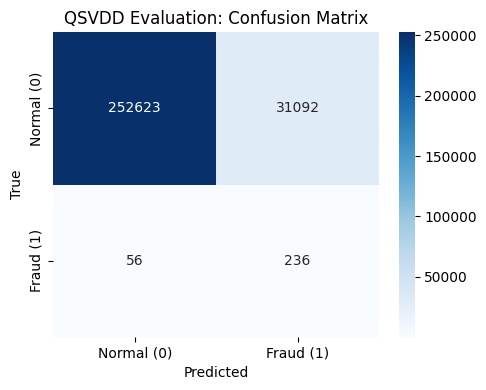

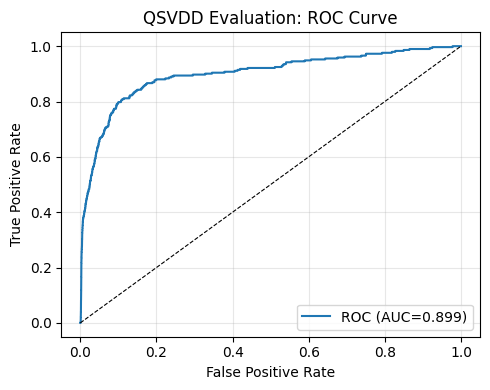

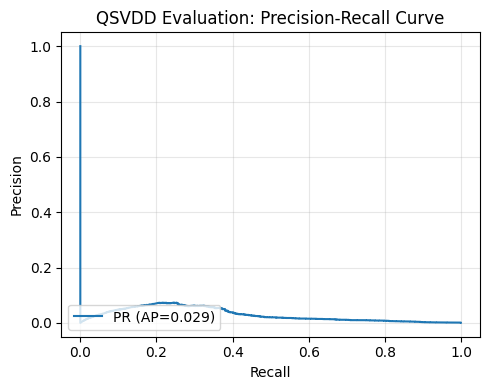


Classification Report:

              precision    recall  f1-score   support

  Normal (0)       1.00      0.89      0.94    283715
   Fraud (1)       0.01      0.81      0.01       292

    accuracy                           0.89    284007
   macro avg       0.50      0.85      0.48    284007
weighted avg       1.00      0.89      0.94    284007



In [27]:
# Evaluation: select threshold, compute metrics, and plot confusion matrix/curves
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)

# Settings: how to pick the decision threshold from anomaly scores
SELECT_BY = 'youden'  # options: 'youden' or 'nu'
PLOT_TITLE_PREFIX = 'QSVDD Evaluation'

def evaluate_and_plot(scores, labels, nu=None, label_names=('Normal (0)', 'Anomalous/Fraud (1)')):
    # Ensure numpy arrays
    scores = np.asarray(scores)
    labels = np.asarray(labels).astype(int)

    # Derive thresholds
    # 1) Youden's J on ROC (default, balances TPR and FPR)
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    youden_idx = int(np.argmax(tpr - fpr)) if len(roc_thresholds) else 0
    thresh_youden = roc_thresholds[youden_idx] if len(roc_thresholds) else float(np.median(scores))

    # 2) Top-nu fraction as anomalies (if nu provided)
    thresh_nu = None
    if nu is not None and 0 < nu < 1:
        # Pick threshold so that ~nu fraction are predicted as anomalies (high score => anomaly)
        quant = max(0.0, min(1.0, 1.0 - float(nu)))
        thresh_nu = float(np.quantile(scores, quant))

    # Choose threshold
    if SELECT_BY.lower() == 'nu' and thresh_nu is not None:
        threshold = thresh_nu
        strategy = f"nu={nu}"
    else:
        threshold = thresh_youden
        strategy = "Youden's J"

    # Predictions
    y_pred = (scores >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(labels, y_pred)
    prec = precision_score(labels, y_pred, zero_division=0)
    rec = recall_score(labels, y_pred, zero_division=0)
    f1 = f1_score(labels, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(labels, scores)
    except ValueError:
        roc_auc = 0.0
    # Precision-Recall AUC (Average Precision)
    try:
        ap = average_precision_score(labels, scores)
    except ValueError:
        ap = 0.0

    print(f"\n=== {PLOT_TITLE_PREFIX} ===")
    print(f"Threshold strategy: {strategy}")
    print(f"Selected threshold: {threshold:.6f}")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print(f"ROC AUC:    {roc_auc:.4f}")
    print(f"PR AUC(AP): {ap:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(labels, y_pred)
    print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_names[0], label_names[1]],
                yticklabels=[label_names[0], label_names[1]])
    plt.title(f'{PLOT_TITLE_PREFIX}: Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if len(fpr) and len(tpr):
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
        plt.plot([0,1],[0,1],'k--', linewidth=0.8)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{PLOT_TITLE_PREFIX}: ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(labels, scores)
    if len(precision) and len(recall):
        plt.figure(figsize=(5,4))
        plt.plot(recall, precision, label=f'PR (AP={ap:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{PLOT_TITLE_PREFIX}: Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    print("\nClassification Report:\n")
    print(classification_report(labels, y_pred, target_names=list(label_names), zero_division=0))

    return {
        'threshold': threshold, 'strategy': strategy,
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'roc_auc': roc_auc, 'pr_auc': ap, 'confusion_matrix': cm, 'y_pred': y_pred,
    }

# Usage: assumes variables `scores` and `labels` are available from the previous test step.
# If you used QSVDD with `nu`, you can pass svdd_model.nu; otherwise leave nu=None.
try:
    nu_value = svdd_model.nu if 'svdd_model' in globals() and hasattr(svdd_model, 'nu') else None
    eval_results = evaluate_and_plot(scores, labels, nu=nu_value, label_names=('Normal (0)', 'Fraud (1)'))
except NameError as e:
    print("Missing variables. Make sure `scores` and `labels` exist from your test step.")
    print("Error:", e)

In [ ]:
# Cell 6: Main Execution (Example)

if __name__ == '__main__': # Or run these lines directly in a notebook cell

    # --- Configuration ---
    DATA_PATH = r"D:\\Academic\\QML Intern\\Anomaly Detection\\Fraud Detection\\creditcard_data.csv" # Update if needed
    N_QUBITS = 8          # Number of qubits (should match PCA components)
    Q_DEPTH_lis = [1, 2]           # Depth of variational circuit (ansatz reps)
    BATCH_SIZE_lis = [16, 32]
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    SIMULATOR_lis = ['aer_statevector', 'qasm_statevector'] # 'reference', 'aer_statevector', 'aer_density_matrix', 'aer_mps'
    NOISE_LEVEL_lis = [0,0.01,0.05]        # Depolarizing error probability (0.0 for noiseless)

    ENCODING_lis = ['angle', 'pauli', 'zz']             # 'angle', 'zz', 'pauli'
    FEATURE_MAP_REPS = 1        # Repetitions for ZZ/Pauli feature map

    PRETRAIN_EPOCHS = 5
    SVDD_EPOCHS_lis = [5, 10]
    LR_lis = [0.005,0.01, 0.05]

    for depth in Q_DEPTH_lis:
        for batch_size in BATCH_SIZE_lis:
            for simulator in SIMULATOR_lis:
                for noise_level in NOISE_LEVEL_lis:
                    for encoding in ENCODING_lis:
                        for svdd_epochs in SVDD_EPOCHS_lis:
                            for lr in LR_lis:
                                logger.info(f"Starting experiment with Q_DEPTH={depth}, BATCH_SIZE={batch_size}, SIMULATOR={simulator}, NOISE_LEVEL={noise_level}, ENCODING={encoding}, SVDD_EPOCHS={svdd_epochs}, LR={lr}")
                                N_QUBITS = 8          # Number of qubits (should match PCA components)
                                Q_DEPTH = depth           # Depth of variational circuit (ansatz reps)
                                BATCH_SIZE = batch_size
                                SIMULATOR = simulator # 'reference', 'aer_statevector', 'aer
                                NOISE_LEVEL = noise_level        # Depolarizing error probability (0.0 for noiseless)
                                ENCODING = encoding             # 'angle', 'zz', 'pauli'
                                SVDD_EPOCHS = svdd_epochs
                                LR = lr

                                # --- Setup ---
                                logger.info(f'Using device: {DEVICE}')

                                # Create the Qiskit Estimator (with optional noise) BEFORE network creation
                                create_estimator(simulator_name=SIMULATOR, noise_level=NOISE_LEVEL)
                                if GLOBAL_ESTIMATOR is None:
                                    raise RuntimeError("Failed to create GLOBAL_ESTIMATOR.")

                                # Load data (adjust parameters as needed)
                                train_loader, test_loader = get_fraud_dataloaders(
                                    data_path=DATA_PATH,
                                    batch_size=BATCH_SIZE,
                                    n_components=N_QUBITS # Ensure PCA matches n_qubits
                                )

                                # --- Model Initialization ---
                                svdd_model = QSVDD(
                                    n_qubits=N_QUBITS,
                                    q_depth=Q_DEPTH,
                                    encoding_map_type=ENCODING,
                                    reps=FEATURE_MAP_REPS
                                )
                                svdd_model.device = DEVICE # Set device for QSVDD internal use

                                # 2. Build main network (just the encoder for PCA'd data)
                                svdd_model.build_autoencoder(classical_hidden_dims=[32]) # Build AE first if pretraining
                                svdd_model.build_main_network()

                                # 3. Transfer weights if pretrained (Optional)
                                # if svdd_model.pretrain_completed:
                                #     svdd_model.transfer_pretrained_encoder(freeze=False)

                                # 4. Train Deep SVDD
                                # Use the internal _train_svdd_with_logging OR the public train_svdd
                                # Make sure _initialize_center_c is called inside train_svdd
                                try:

                                    svdd_model.pretrain(
                                        train_loader=train_loader,
                                        test_loader=test_loader, # Pass test_loader
                                        n_epochs=PRETRAIN_EPOCHS,
                                        lr=LR*5, # Often higher LR for AE pretrain
                                    )
                                    svdd_model.train_svdd(
                                        train_loader=train_loader,
                                        lr=LR,
                                        n_epochs=SVDD_EPOCHS,
                                        device=DEVICE
                                    )
                                except Exception as e:
                                    logger.error(f"SVDD Training failed: {e}", exc_info=True)
                                    # Optionally dump parameter info again on failure
                                    if svdd_model.net:
                                        for n, p in svdd_model.net.named_parameters():
                                            print(f'[FAIL DUMP] Param {n}: req_grad={p.requires_grad} dtype={p.dtype} device={p.device} grad?={p.grad is not None}')
                                    raise

                                # 5. Evaluate
                                if svdd_model.net and svdd_model.c is not None:
                                    scores, labels, auc = svdd_model.test(test_loader)
                                    logger.info(f"Final Test AUC: {auc}")
                                    # logger.info(f"First 5 anomaly scores: {scores[:5] if scores is not None else 'N/A'}")
                                else:
                                    logger.error("Skipping testing as training did not complete successfully.")

                                # --- Cleanup/Analysis ---
                                # You can now access svdd_model.results, svdd_model.svdd_losses_per_epoch etc.
                                # Add plotting code here if desired (like the cells you provided before)


                                # Settings: how to pick the decision threshold from anomaly scores
                                SELECT_BY = 'youden'  # options: 'youden' or 'nu'
                                # Create a detailed title prefix for the plots
                                PLOT_TITLE_PREFIX = (
                                    f"QSVDD (Depth={Q_DEPTH}, Batch={BATCH_SIZE}, LR={LR})\n"
                                    f"Sim={SIMULATOR}, Noise={NOISE_LEVEL}, Enc={ENCODING}, Epochs={SVDD_EPOCHS}"
                                )

                                print(f'For Depth = {Q_DEPTH}, Batch size = {BATCH_SIZE}, Simulator = {SIMULATOR}, Noise level = {NOISE_LEVEL}, Encoding = {ENCODING}, Epochs = {SVDD_EPOCHS}, Learning Rate = {LR}')

                                def evaluate_and_plot(scores, labels, nu=None, label_names=('Normal (0)', 'Anomalous/Fraud (1)')):
                                    # Ensure numpy arrays
                                    scores = np.asarray(scores)
                                    labels = np.asarray(labels).astype(int)

                                    # Derive thresholds
                                    # 1) Youden's J on ROC (default, balances TPR and FPR)
                                    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
                                    youden_idx = int(np.argmax(tpr - fpr)) if len(roc_thresholds) else 0
                                    thresh_youden = roc_thresholds[youden_idx] if len(roc_thresholds) else float(np.median(scores))

                                    # 2) Top-nu fraction as anomalies (if nu provided)
                                    thresh_nu = None
                                    if nu is not None and 0 < nu < 1:
                                        # Pick threshold so that ~nu fraction are predicted as anomalies (high score => anomaly)
                                        quant = max(0.0, min(1.0, 1.0 - float(nu)))
                                        thresh_nu = float(np.quantile(scores, quant))

                                    # Choose threshold
                                    if SELECT_BY.lower() == 'nu' and thresh_nu is not None:
                                        threshold = thresh_nu
                                        strategy = f"nu={nu}"
                                    else:
                                        threshold = thresh_youden
                                        strategy = "Youden's J"

                                    # Predictions
                                    y_pred = (scores >= threshold).astype(int)

                                    # Metrics
                                    acc = accuracy_score(labels, y_pred)
                                    prec = precision_score(labels, y_pred, zero_division=0)
                                    rec = recall_score(labels, y_pred, zero_division=0)
                                    f1 = f1_score(labels, y_pred, zero_division=0)
                                    try:
                                        roc_auc = roc_auc_score(labels, scores)
                                    except ValueError:
                                        roc_auc = 0.0
                                    # Precision-Recall AUC (Average Precision)
                                    try:
                                        ap = average_precision_score(labels, scores)
                                    except ValueError:
                                        ap = 0.0
                                    
                                    
                                    print(f"\n=== {PLOT_TITLE_PREFIX} ===")
                                    print(f"Threshold strategy: {strategy}")
                                    print(f"Selected threshold: {threshold:.6f}")
                                    print(f"Accuracy:   {acc:.4f}")
                                    print(f"Precision:  {prec:.4f}")
                                    print(f"Recall:     {rec:.4f}")
                                    print(f"F1-score:   {f1:.4f}")
                                    print(f"ROC AUC:    {roc_auc:.4f}")
                                    print(f"PR AUC(AP): {ap:.4f}")

                                    # Confusion Matrix
                                    cm = confusion_matrix(labels, y_pred)
                                    print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)
                                    plt.figure(figsize=(5,4))
                                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                                xticklabels=[label_names[0], label_names[1]],
                                                yticklabels=[label_names[0], label_names[1]])
                                    plt.title(f'{PLOT_TITLE_PREFIX}: Confusion Matrix')
                                    plt.xlabel('Predicted')
                                    plt.ylabel('True')
                                    plt.tight_layout()
                                    plt.show()

                                    # ROC Curve
                                    if len(fpr) and len(tpr):
                                        plt.figure(figsize=(5,4))
                                        plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
                                        plt.plot([0,1],[0,1],'k--', linewidth=0.8)
                                        plt.xlabel('False Positive Rate')
                                        plt.ylabel('True Positive Rate')
                                        plt.title(f'{PLOT_TITLE_PREFIX}: ROC Curve')
                                        plt.legend(loc='lower right')
                                        plt.grid(alpha=0.3)
                                        plt.tight_layout()
                                        plt.show()

                                    # Precision-Recall Curve
                                    precision, recall, _ = precision_recall_curve(labels, scores)
                                    if len(precision) and len(recall):
                                        plt.figure(figsize=(5,4))
                                        plt.plot(recall, precision, label=f'PR (AP={ap:.3f})')
                                        plt.xlabel('Recall')
                                        plt.ylabel('Precision')
                                        plt.title(f'{PLOT_TITLE_PREFIX}: Precision-Recall Curve')
                                        plt.legend(loc='lower left')
                                        plt.grid(alpha=0.3)
                                        plt.tight_layout()
                                        plt.show()

                                    print("\nClassification Report:\n")
                                    print(classification_report(labels, y_pred, target_names=list(label_names), zero_division=0))

                                    return {
                                        'threshold': threshold, 'strategy': strategy,
                                        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
                                        'roc_auc': roc_auc, 'pr_auc': ap, 'confusion_matrix': cm, 'y_pred': y_pred,
                                    }

                                # Usage: assumes variables `scores` and `labels` are available from the previous test step.
                                # If you used QSVDD with `nu`, you can pass svdd_model.nu; otherwise leave nu=None.
                                try:
                                    nu_value = svdd_model.nu if 'svdd_model' in globals() and hasattr(svdd_model, 'nu') else None
                                    eval_results = evaluate_and_plot(scores, labels, nu=nu_value, label_names=('Normal (0)', 'Fraud (1)'))
                                except NameError as e:
                                    print("Missing variables. Make sure `scores` and `labels` exist from your test step.")
                                    print("Error:", e)

In [ ]:
# Cell 6: Main Execution (Example)

# --- Imports needed for the evaluation function ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, classification_report
)
import os
# --------------------------------------------------

if __name__ == '__main__': # Or run these lines directly in a notebook cell

    # --- Configuration ---
    DATA_PATH = r"D:\\Academic\\QML_Intern\\Anomaly_Detection\\Fraud_Detection\\creditcard_data.csv" # Update if needed
    N_QUBITS = 8          # Number of qubits (should match PCA components)
    Q_DEPTH_lis = [1, 2]         # Depth of variational circuit (ansatz reps)
    BATCH_SIZE_lis = [16, 32]
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    SIMULATOR_lis = ['aer_statevector'] # 'reference', 'aer_statevector', 'aer_density_matrix', 'aer_mps'
    NOISE_LEVEL_lis = [0, 0.01]         # Depolarizing error probability (0.0 for noiseless)

    ENCODING_lis = ['angle', 'zz']          # 'angle', 'zz', 'pauli'
    FEATURE_MAP_REPS = 1        # Repetitions for ZZ/Pauli feature map

    PRETRAIN_EPOCHS = 5
    SVDD_EPOCHS_lis = [5, 10]
    LR_lis = [0.005, 0.01]

    # --- *** UPDATED: Create a directory to save plots *** ---
    PLOT_DIR = r"D:\Academic\QML_Intern\Anomaly_Detection\Fraud_Detection\Fraud_Detection_QML\plots"
    os.makedirs(PLOT_DIR, exist_ok=True)
    logger.info(f"Plots will be saved to '{PLOT_DIR}' directory.")
    # ---------------------------------------------------------

    # --- Result storage ---
    all_experiment_results = []
    # ----------------------

    for depth in Q_DEPTH_lis:
        for batch_size in BATCH_SIZE_lis:
            for simulator in SIMULATOR_lis:
                for noise_level in NOISE_LEVEL_lis:
                    for encoding in ENCODING_lis:
                        for svdd_epochs in SVDD_EPOCHS_lis:
                            for lr in LR_lis:
                                # Skip invalid combinations
                                if encoding == 'zz' and N_QUBITS < 2:
                                    logger.warning(f"Skipping ZZ encoding for N_QUBITS={N_QUBITS} < 2")
                                    continue
                                
                                # --- Create a unique ID for this run ---
                                run_id = (
                                    f"D{depth}_B{batch_size}_LR{str(lr).replace('.', 'p')}_"
                                    f"Sim-{simulator}_Noise-{str(noise_level).replace('.', 'p')}_Enc-{encoding}_Ep{svdd_epochs}"
                                )
                                logger.info(f"--- Starting Experiment: {run_id} ---")
                                
                                Q_DEPTH = depth
                                BATCH_SIZE = batch_size
                                SIMULATOR = simulator
                                NOISE_LEVEL = noise_level
                                ENCODING = encoding
                                SVDD_EPOCHS = svdd_epochs
                                LR = lr

                                # --- Setup ---
                                logger.info(f'Using device: {DEVICE}')
                                create_estimator(simulator_name=SIMULATOR, noise_level=NOISE_LEVEL)
                                if GLOBAL_ESTIMATOR is None:
                                    raise RuntimeError("Failed to create GLOBAL_ESTIMATOR.")

                                train_loader, test_loader = get_fraud_dataloaders(
                                    data_path=DATA_PATH,
                                    batch_size=BATCH_SIZE,
                                    n_components=N_QUBITS
                                )

                                # --- Model Initialization ---
                                svdd_model = QSVDD(
                                    n_qubits=N_QUBITS,
                                    q_depth=Q_DEPTH,
                                    encoding_map_type=ENCODING,
                                    reps=FEATURE_MAP_REPS,
                                    nu=0.1 # Example nu, adjust as needed
                                )
                                svdd_model.device = DEVICE

                                # --- Build Networks ---
                                svdd_model.build_autoencoder(classical_hidden_dims=[32])
                                svdd_model.build_main_network()

                                # --- Training ---
                                scores, labels, auc = None, None, None # Initialize
                                try:
                                    svdd_model.pretrain(
                                        train_loader=train_loader,
                                        test_loader=test_loader,
                                        n_epochs=PRETRAIN_EPOCHS,
                                        lr=LR*5,
                                        device=DEVICE
                                    )
                                    svdd_model.train_svdd(
                                        train_loader=train_loader,
                                        lr=LR,
                                        n_epochs=SVDD_EPOCHS,
                                        device=DEVICE
                                    )
                                except Exception as e:
                                    logger.error(f"SVDD Training failed for {run_id}: {e}", exc_info=True)
                                    continue # Skip testing and plotting for this failed run

                                # 5. Evaluate
                                if svdd_model.net and svdd_model.c is not None:
                                    scores, labels, auc = svdd_model.test(test_loader)
                                    logger.info(f"Final Test AUC for {run_id}: {auc}")
                                else:
                                    logger.error(f"Skipping testing for {run_id} as training did not complete successfully.")
                                    continue # Skip plotting for this failed run
                                
                                # --- START of Plotting/Saving Section ---

                                # Settings: how to pick the decision threshold
                                SELECT_BY = 'youden'  # options: 'youden' or 'nu'

                                # Create a detailed title prefix for the plots
                                PLOT_TITLE_PREFIX = (
                                    f"QSVDD (Depth={Q_DEPTH}, Batch={BATCH_SIZE}, LR={LR})\n"
                                    f"Sim={SIMULATOR}, Noise={NOISE_LEVEL}, Enc={ENCODING}, Epochs={SVDD_EPOCHS}"
                                )
                                
                                # Create a unique filename prefix
                                FILENAME_PREFIX = os.path.join(PLOT_DIR, run_id)
                                
                                # (Define function inside loop to capture local vars like PLOT_TITLE_PREFIX)
                                def evaluate_and_plot(scores, labels, nu=None, label_names=('Normal (0)', 'Anomalous/Fraud (1)'), 
                                                      title_prefix='Evaluation', filename_prefix='eval'):
                                    
                                    scores = np.asarray(scores)
                                    labels = np.asarray(labels).astype(int)
                                    
                                    # Check for valid data
                                    if len(scores) == 0 or len(labels) == 0:
                                        logger.error("Empty scores or labels, skipping plotting.")
                                        return None
                                    if len(np.unique(labels)) < 2:
                                        logger.warning(f"Only one class ({np.unique(labels)}) present in labels. ROC/PR curves may be uninformative.")
                                        
                                    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
                                    youden_idx = int(np.argmax(tpr - fpr)) if len(roc_thresholds) > 0 else 0
                                    thresh_youden = roc_thresholds[youden_idx] if len(roc_thresholds) > 0 else float(np.median(scores))
                                    
                                    thresh_nu = None
                                    if nu is not None and 0 < nu < 1:
                                        quant = max(0.0, min(1.0, 1.0 - float(nu)))
                                        thresh_nu = float(np.quantile(scores, quant))
                                    
                                    if SELECT_BY.lower() == 'nu' and thresh_nu is not None:
                                        threshold = thresh_nu
                                        strategy = f"nu={nu}"
                                    else:
                                        threshold = thresh_youden
                                        strategy = "Youden's J"
                                    
                                    y_pred = (scores >= threshold).astype(int)
                                    
                                    acc = accuracy_score(labels, y_pred)
                                    prec = precision_score(labels, y_pred, zero_division=0)
                                    rec = recall_score(labels, y_pred, zero_division=0)
                                    f1 = f1_score(labels, y_pred, zero_division=0)
                                    
                                    try: 
                                        roc_auc = roc_auc_score(labels, scores)
                                    except ValueError: 
                                        roc_auc = 0.0
                                    try: 
                                        ap = average_precision_score(labels, scores)
                                    except ValueError: 
                                        ap = 0.0

                                    print(f"\n=== {title_prefix} ===")
                                    print(f"Threshold strategy: {strategy}")
                                    print(f"Selected threshold: {threshold:.6f}")
                                    print(f"Accuracy:   {acc:.4f}")
                                    print(f"Precision:  {prec:.4f}")
                                    print(f"Recall:     {rec:.4f}")
                                    print(f"F1-score:   {f1:.4f}")
                                    print(f"ROC AUC:    {roc_auc:.4f}")
                                    print(f"PR AUC(AP): {ap:.4f}")

                                    # Confusion Matrix
                                    cm = confusion_matrix(labels, y_pred)
                                    print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)
                                    plt.figure(figsize=(6, 5)) # Adjusted size
                                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                                xticklabels=[label_names[0], label_names[1]],
                                                yticklabels=[label_names[0], label_names[1]])
                                    plt.title(f'{title_prefix}:\nConfusion Matrix', fontsize=10) # Added \n
                                    plt.xlabel('Predicted')
                                    plt.ylabel('True')
                                    plt.tight_layout()
                                    plt.savefig(f"{filename_prefix}_cm.png", dpi=150)
                                    plt.show()

                                    # ROC Curve
                                    if len(fpr) > 0 and len(tpr) > 0:
                                        plt.figure(figsize=(6, 5)) # Adjusted size
                                        plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
                                        plt.plot([0,1],[0,1],'k--', linewidth=0.8)
                                        plt.xlabel('False Positive Rate')
                                        plt.ylabel('True Positive Rate')
                                        plt.title(f'{title_prefix}:\nROC Curve', fontsize=10) # Added \n
                                        plt.legend(loc='lower right')
                                        plt.grid(alpha=0.3)
                                        plt.tight_layout()
                                        plt.savefig(f"{filename_prefix}_roc.png", dpi=150)
                                        plt.show()

                                    # Precision-Recall Curve
                                    precision, recall, _ = precision_recall_curve(labels, scores)
                                    if len(precision) > 0 and len(recall) > 0:
                                        plt.figure(figsize=(6, 5)) # Adjusted size
                                        plt.plot(recall, precision, label=f'PR (AP={ap:.3f})')
                                        plt.xlabel('Recall')
                                        plt.ylabel('Precision')
                                        plt.title(f'{title_prefix}:\nPrecision-Recall Curve', fontsize=10) # Added \n
                                        plt.legend(loc='lower left')
                                        plt.grid(alpha=0.3)
                                        plt.tight_layout()
                                        plt.savefig(f"{filename_prefix}_pr.png", dpi=150)
                                        plt.show()

                                    print("\nClassification Report:\n")
                                    print(classification_report(labels, y_pred, target_names=list(label_names), zero_division=0))
                                    
                                    run_results = {
                                        'threshold': threshold, 'strategy': strategy,
                                        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
                                        'roc_auc': roc_auc, 'pr_auc': ap, 'confusion_matrix': cm
                                    }
                                    return run_results

                                # --- Function Call ---
                                try:
                                    if scores is not None and labels is not None:
                                        nu_value = svdd_model.nu
                                        eval_results = evaluate_and_plot(
                                            scores, labels, 
                                            nu=nu_value, 
                                            label_names=('Normal (0)', 'Fraud (1)'),
                                            title_prefix=PLOT_TITLE_PREFIX,
                                            filename_prefix=FILENAME_PREFIX
                                        )
                                        
                                        # Store results
                                        if eval_results:
                                            experiment_params = {
                                                "run_id": run_id, "Q_DEPTH": Q_DEPTH, "BATCH_SIZE": BATCH_SIZE,
                                                "LR": LR, "SIMULATOR": SIMULATOR, "NOISE_LEVEL": NOISE_LEVEL,
                                                "ENCODING": ENCODING, "SVDD_EPOCHS": SVDD_EPOCHS
                                            }
                                            all_experiment_results.append({**experiment_params, **eval_results})
                                            
                                    else:
                                        logger.error(f"Skipping plotting for {run_id}, scores/labels not available.")
                                        
                                except NameError as e:
                                    logger.error(f"Plotting failed for {run_id}: {e}", exc_info=True)
                                
                                logger.info(f"--- Finished Experiment: {run_id} ---")

    # --- End of all loops ---
    logger.info("All experiments finished.")

    # Optional: Save all results to a file
    try:
        results_df = pd.DataFrame(all_experiment_results)
        results_df.to_csv(os.path.join(PLOT_DIR, "all_experiment_results.csv"), index=False)
        logger.info(f"All experiment results saved to {os.path.join(PLOT_DIR, 'all_experiment_results.csv')}")
    except Exception as e:
        logger.error(f"Failed to save all experiment results: {e}")